In [1]:
pip install pca

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster import hierarchy
from scipy import stats
import logging, sys
logging.disable(sys.maxsize)
#https://erdogant.github.io/pca
from pca import pca
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


Import Data

In [3]:
import pandas as pd
akuna_data = pd.read_csv("data/akuna_data.csv",)

print("DataFrame: akuna_data")
akuna_data.head(8)

DataFrame: akuna_data


,Submission ID,Respondent ID,Submitted at,In che lingua preferisci svolgere questo sondaggio? - \nIn which language would you prefer to take the survey?,Hai mai acquistato delle scarpe da calcio?,Qual è il tuo genere?,Che lavoro fai?,Da dove provieni?,Quanti anni hai?,"Di solito, in che ruolo giochi?",...,Performance (10),Quality (5),At what price would the product seem so low in quality that you would no longer consider buying it?\n,At what price would the product start to seem like a very good deal?\n,At what price would you start to consider the product too expensive?\n,At what price would the product be so expensive that you would no longer consider buying it?\n,At what price would the product seem so low in quality that you would no longer consider buying it?\n (2),At what price would the product start to seem like a very good deal?\n (2),At what price would you start to consider the product too expensive?\n (2),At what price would the product be so expensive that you would no longer consider buying it?\n (2)
0,rjXaBGX,PdANzXP,2026-02-05 14:27:37,Italiano,No,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,jaK66l4,yPlbJQp,2026-02-05 14:29:56,English,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,35.0,50.0,80.0,100.0,35.0,50.0,80.0,100.0
2,44ZJJyr,WOA6zzN,2026-02-05 14:31:37,Italiano,Sì,Maschio,Dipendente,Puglia,30.0,Centrocampista,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ZjxEEMz,zxKAYZq,2026-02-05 14:32:21,English,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,15.0,25.0,75.0,100.0,15.0,25.0,80.0,120.0
4,GxM998j,yPlbYE0,2026-02-05 14:32:37,Italiano,No,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,RGOMoxP,yPlbYeW,2026-02-05 14:33:04,Italiano,Sì,Maschio,Studente,Puglia,24.0,Difensore,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,RGOMD2J,442Yx9b,2026-02-05 14:38:07,English,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,25.0,50.0,100.0,150.0,25.0,50.0,100.0,150.0
7,GxM9l2Q,aQB16rb,2026-02-05 14:42:44,Italiano,Sì,Maschio,Studente,Lombardia,24.0,Attaccante,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Segmentation
Import Segmentation Data

Dataset Info

In [4]:

akuna_data.info()

<class 'pandas.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Columns: 110 entries, Submission ID to At what price would the product be so expensive that you would no longer consider buying it?
 (2)
dtypes: float64(86), str(24)
memory usage: 100.7 KB


In [5]:
ita_indices = range(14, 23)
eng_indices = range(67, 85)

clean_names = [
    "Boot weight", "Softness of material", "Foot Fit", "Durability", 
    "Brand Reputation", "Ball control", "Ease of fit", "Color options", "Quality Preference"
]
akuna_segmentation_data = pd.DataFrame()

for i in range(len(clean_names)):
    ita_col_name = akuna_data.columns[ita_indices[i]]
    eng_col_name = akuna_data.columns[eng_indices[i]]
    akuna_segmentation_data[clean_names[i]] = akuna_data[eng_col_name].combine_first(akuna_data[ita_col_name])

akuna_segmentation_data.dropna(inplace=True)
print(akuna_segmentation_data.head())

   Boot weight  Softness of material  Foot Fit  Durability  Brand Reputation  \
1          2.0                   2.0       5.0         4.0               5.0   
2          3.0                   3.0       5.0         5.0               2.0   
3          2.0                   4.0       5.0         5.0               4.0   
5          2.0                   3.0       5.0         4.0               3.0   
6          3.0                   1.0       5.0         5.0               2.0   

   Ball control  Ease of fit  Color options  Quality Preference  
1           5.0          5.0            2.0                 5.0  
2           2.0          2.0            1.0                 2.0  
3           4.0          2.0            1.0                 4.0  
5           5.0          1.0            1.0                 5.0  
6           3.0          5.0            1.0                 4.0  


dataset description

In [6]:
akuna_segmentation_data.describe().style.format("{:.1f}")

,Boot weight,Softness of material,Foot Fit,Durability,Brand Reputation,Ball control,Ease of fit,Color options,Quality Preference
count,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0
mean,3.0,3.9,4.5,4.1,2.4,3.9,2.4,1.9,3.8
std,1.0,1.0,0.7,0.9,1.2,1.2,1.3,1.1,1.1
min,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,2.0,3.0,4.0,4.0,1.0,3.0,1.0,1.0,3.0
50%,3.0,4.0,5.0,4.0,2.0,4.0,2.0,2.0,4.0
75%,4.0,5.0,5.0,5.0,3.0,5.0,3.0,3.0,5.0
max,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


clustering

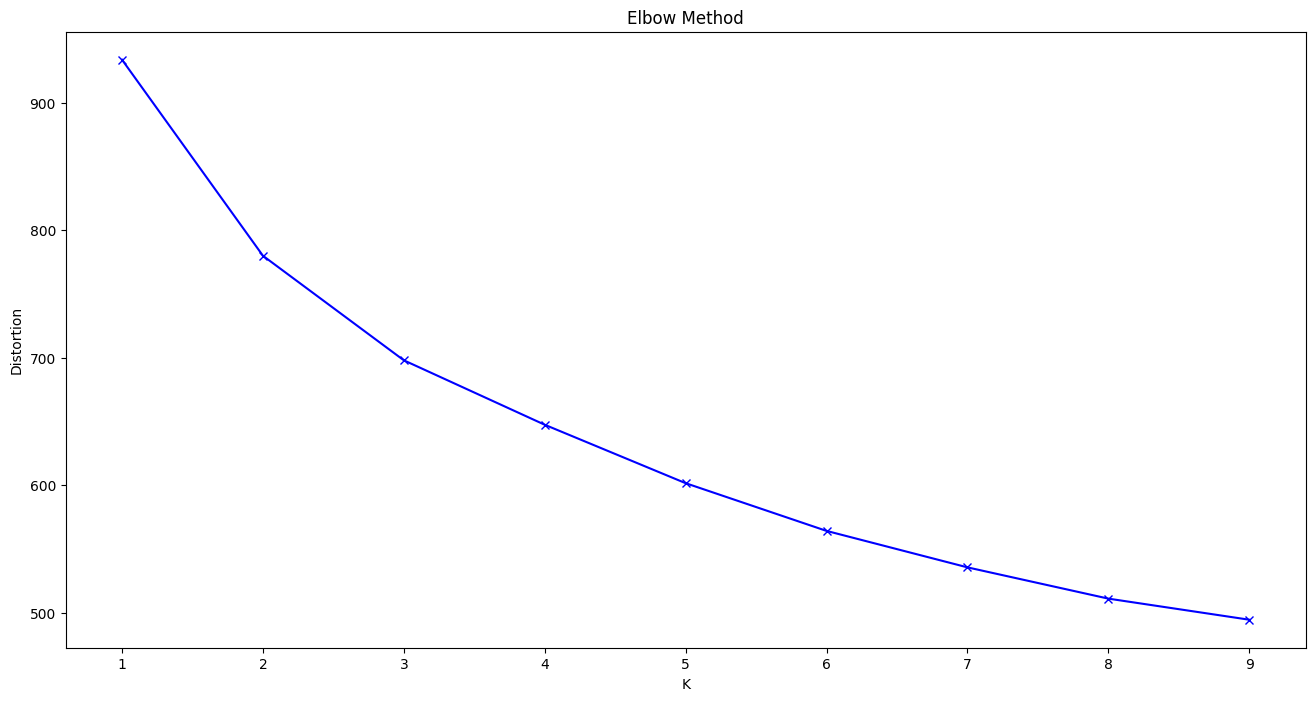

In [7]:
warnings.filterwarnings("ignore")

distortions = [KMeans(n_clusters=K).fit(akuna_segmentation_data).inertia_ for K in range(1,10)]
    
plt.figure(figsize=(16,8))
plt.plot(range(1,10), distortions, 'bx-')
plt.xlabel('K'); plt.ylabel('Distortion'); plt.title('Elbow Method');

Silhouette Analysis

For n_clusters = 2 The average silhouette_score is : 0.13835851547348088
For n_clusters = 3 The average silhouette_score is : 0.09385088080420913
For n_clusters = 4 The average silhouette_score is : 0.1024171323031649
For n_clusters = 5 The average silhouette_score is : 0.10565213900431537


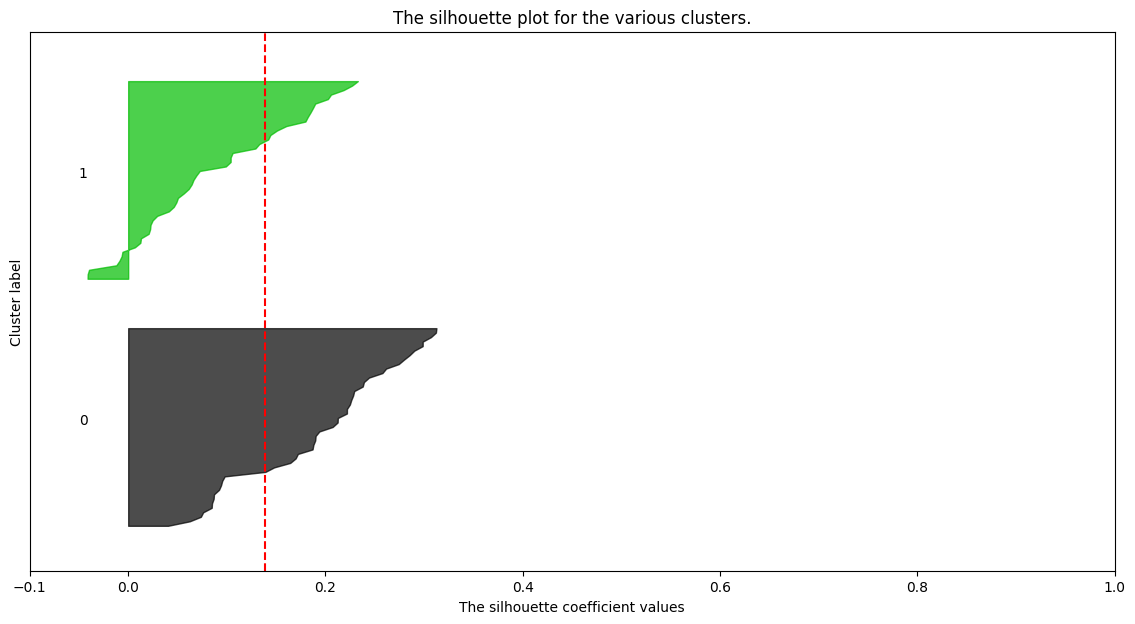

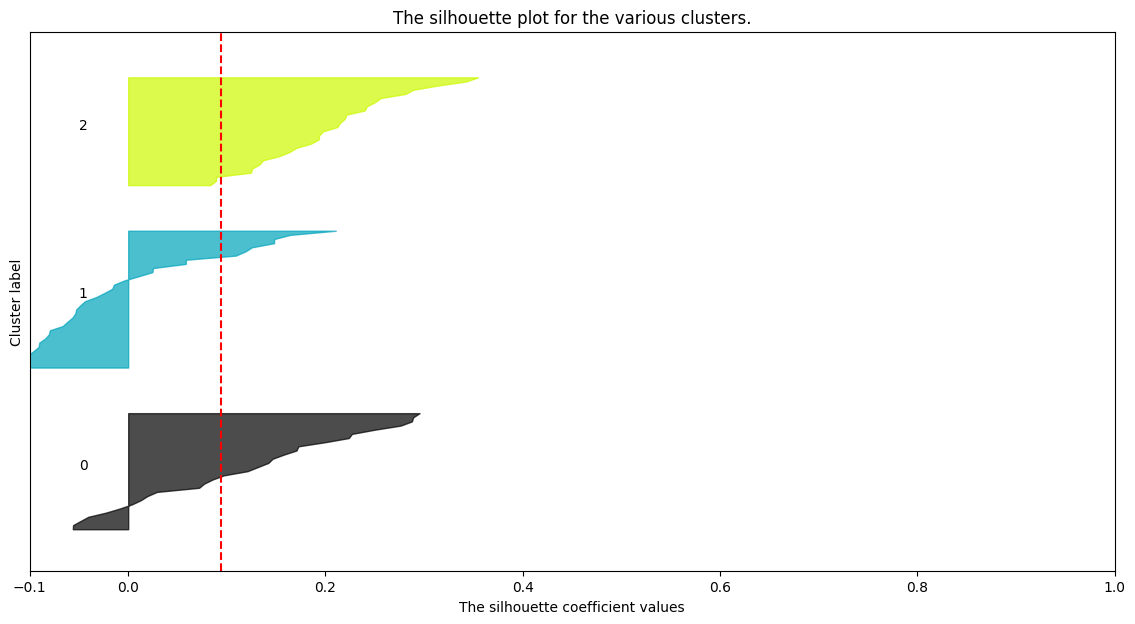

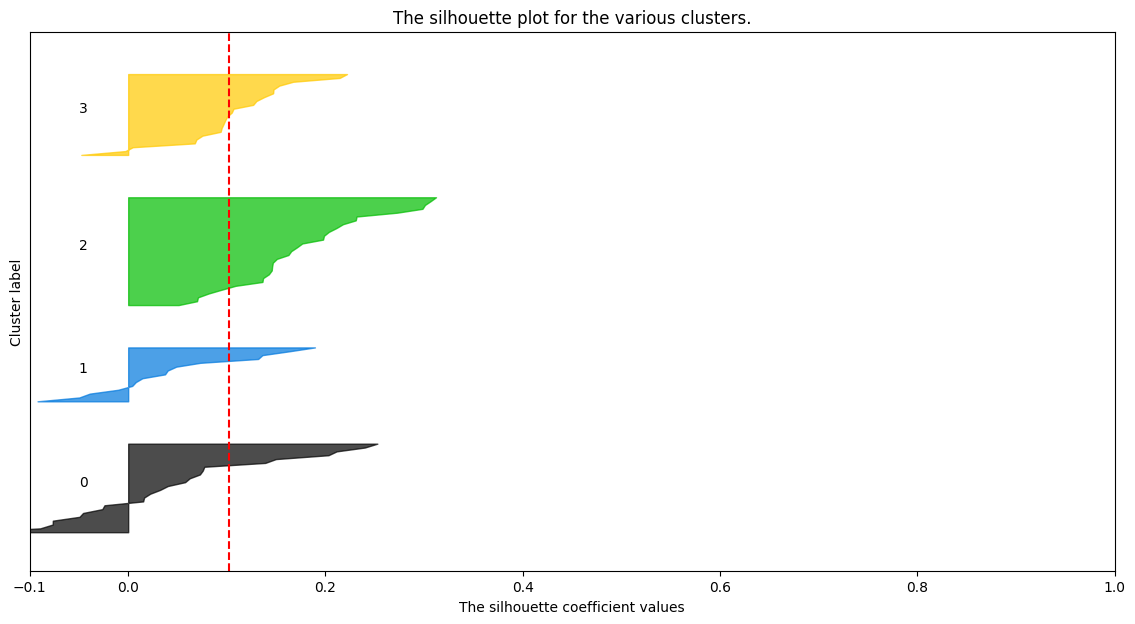

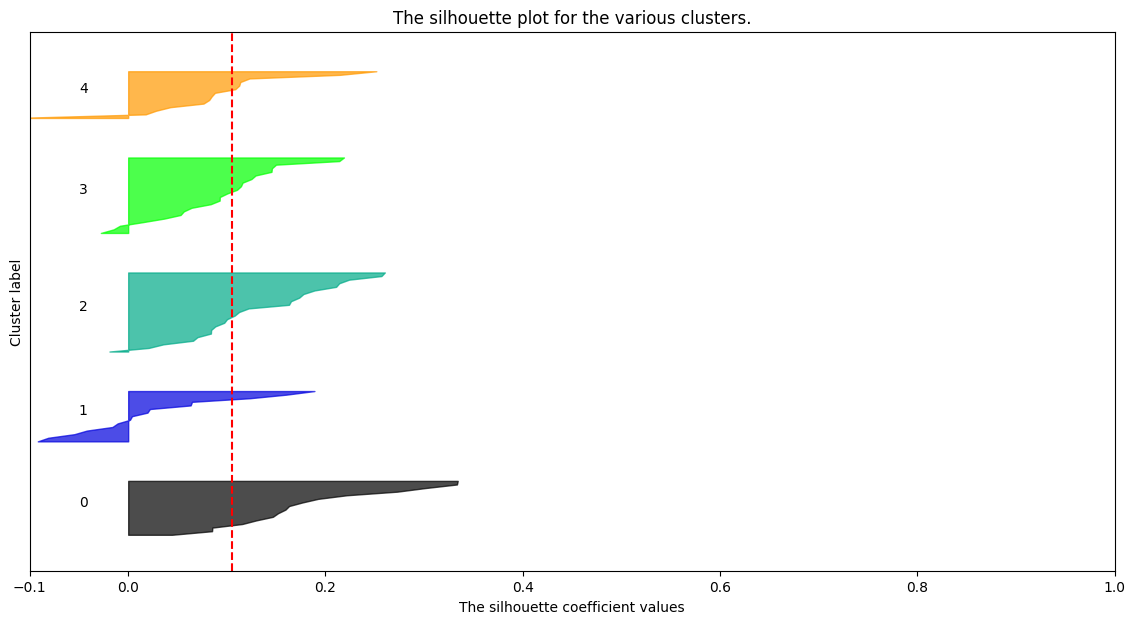

In [8]:
X = akuna_segmentation_data.to_numpy()
range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 7)

    # Silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters,random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

Silhouette plots show weak structure: most coefficients are close to 0 (some negative), so clusters overlap heavily.
Average silhouette decreases as k increases; k=2 appears relatively best but still indicates only coarse segmentation.

n Segments solution using K-Means

In [9]:
# Perform clustering with K=n, relabel cluster to [1,2,3], add cluster labels back to dataset and show first 8 rows
akuna_segmentation_data["SegmentKM"] = KMeans(n_clusters=3,random_state=42).fit(akuna_segmentation_data).labels_
akuna_segmentation_data["SegmentKM"] = akuna_segmentation_data["SegmentKM"] + 1
akuna_segmentation_data.head(8)

,Boot weight,Softness of material,Foot Fit,Durability,Brand Reputation,Ball control,Ease of fit,Color options,Quality Preference,SegmentKM
1,2.0,2.0,5.0,4.0,5.0,5.0,5.0,2.0,5.0,1
2,3.0,3.0,5.0,5.0,2.0,2.0,2.0,1.0,2.0,2
3,2.0,4.0,5.0,5.0,4.0,4.0,2.0,1.0,4.0,2
5,2.0,3.0,5.0,4.0,3.0,5.0,1.0,1.0,5.0,2
6,3.0,1.0,5.0,5.0,2.0,3.0,5.0,1.0,4.0,3
7,4.0,3.0,4.0,4.0,1.0,4.0,1.0,1.0,2.0,2
9,4.0,4.0,3.0,5.0,2.0,5.0,2.0,1.0,4.0,2
13,4.0,3.0,4.0,5.0,2.0,5.0,3.0,2.0,4.0,3


In [10]:
# Segment sizes 
akuna_segmentation_data_Sizes = pd.DataFrame(akuna_segmentation_data.groupby("SegmentKM").size(),columns=["Size"]).T
akuna_segmentation_data_Sizes.insert(0,"Population",len(akuna_segmentation_data))
akuna_segmentation_data_Sizes.loc["%"] = akuna_segmentation_data_Sizes.iloc[0].div(akuna_segmentation_data_Sizes.iloc[0,0]).mul(100).astype(int)
akuna_segmentation_data_Sizes

SegmentKM,Population,1,2,3
Size,90,20,45,25
%,100,22,50,27


Segments description

In [11]:
akuna_segmentation_data_Means = akuna_segmentation_data.groupby("SegmentKM").mean().T
akuna_segmentation_data_Means.insert(0,"Population",akuna_segmentation_data.drop(columns="SegmentKM").mean())
akuna_segmentation_data_Means.round(2)

SegmentKM,Population,1,2,3
Boot weight,2.98,3.35,2.76,3.08
Softness of material,3.90,4.25,3.73,3.92
Foot Fit,4.49,4.70,4.47,4.36
Durability,4.14,4.35,4.16,3.96
Brand Reputation,2.40,3.70,2.07,1.96
Ball control,3.89,4.55,3.67,3.76
Ease of fit,2.41,2.95,1.47,3.68
Color options,1.93,3.15,1.36,2.00
Quality Preference,3.77,4.50,3.31,4.00


In [12]:
# Significance of means differences between each segment and the rest of the population
# Using appropriate t-test imported from scipy or statsmodel package and setting colors using DataFrame’s style attribute
from scipy import stats
#from statsmodels.stats import weightstats as st

X = akuna_segmentation_data.copy()

def style_cols(col):
    if col.name == "Population": return ["background-color: white"]*len(col)
    
    segment = X[X.SegmentKM == col.name]
    rest_pop = X[X.SegmentKM != col.name]
    
    colors = []
    for var_name, var_segment_mean in col.items():
        t_test, p_value = stats.ttest_ind(segment[var_name], rest_pop[var_name],equal_var=False)
        #_,p_value,_ = st.ttest_ind(segment[var_name],rest_pop[var_name],usevar="unequal")    
        if p_value < 0.05:
            color = "background-color: green" if var_segment_mean > rest_pop[var_name].mean() else "background-color: red"
        elif p_value < 0.1:
            color = "background-color: #90ee90" if var_segment_mean > rest_pop[var_name].mean() else "background-color: #f1807e"
        else: color = "background-color: white"
        colors.append(color)
    return colors

akuna_segmentation_data_Means.style.apply(style_cols).format("{:.2f}")

SegmentKM,Population,1,2,3
Boot weight,2.98,3.35,2.76,3.08
Softness of material,3.90,4.25,3.73,3.92
Foot Fit,4.49,4.70,4.47,4.36
Durability,4.14,4.35,4.16,3.96
Brand Reputation,2.40,3.70,2.07,1.96
Ball control,3.89,4.55,3.67,3.76
Ease of fit,2.41,2.95,1.47,3.68
Color options,1.93,3.15,1.36,2.00
Quality Preference,3.77,4.50,3.31,4.00


Cell colors indicate mean differences vs population: strong colors p<0.05, lighter colors 0.05<=p<0.10; green/red denote higher/lower importance.
* Segment 1: Performance-oriented profile, with significantly higher importance placed on ball control, foot fit, durability, and overall quality.
* Segment 2: Low-engagement profile, consistently assigning lower importance to brand, ease of fit, color options, and quality-related attributes.
* Segment 3: Comfort- and fit-focused profile, emphasizing ease of fit and material softness, with less emphasis on brand reputation.

Segmentation space using PCA (with pca package)

ValueError: assignment destination is read-only

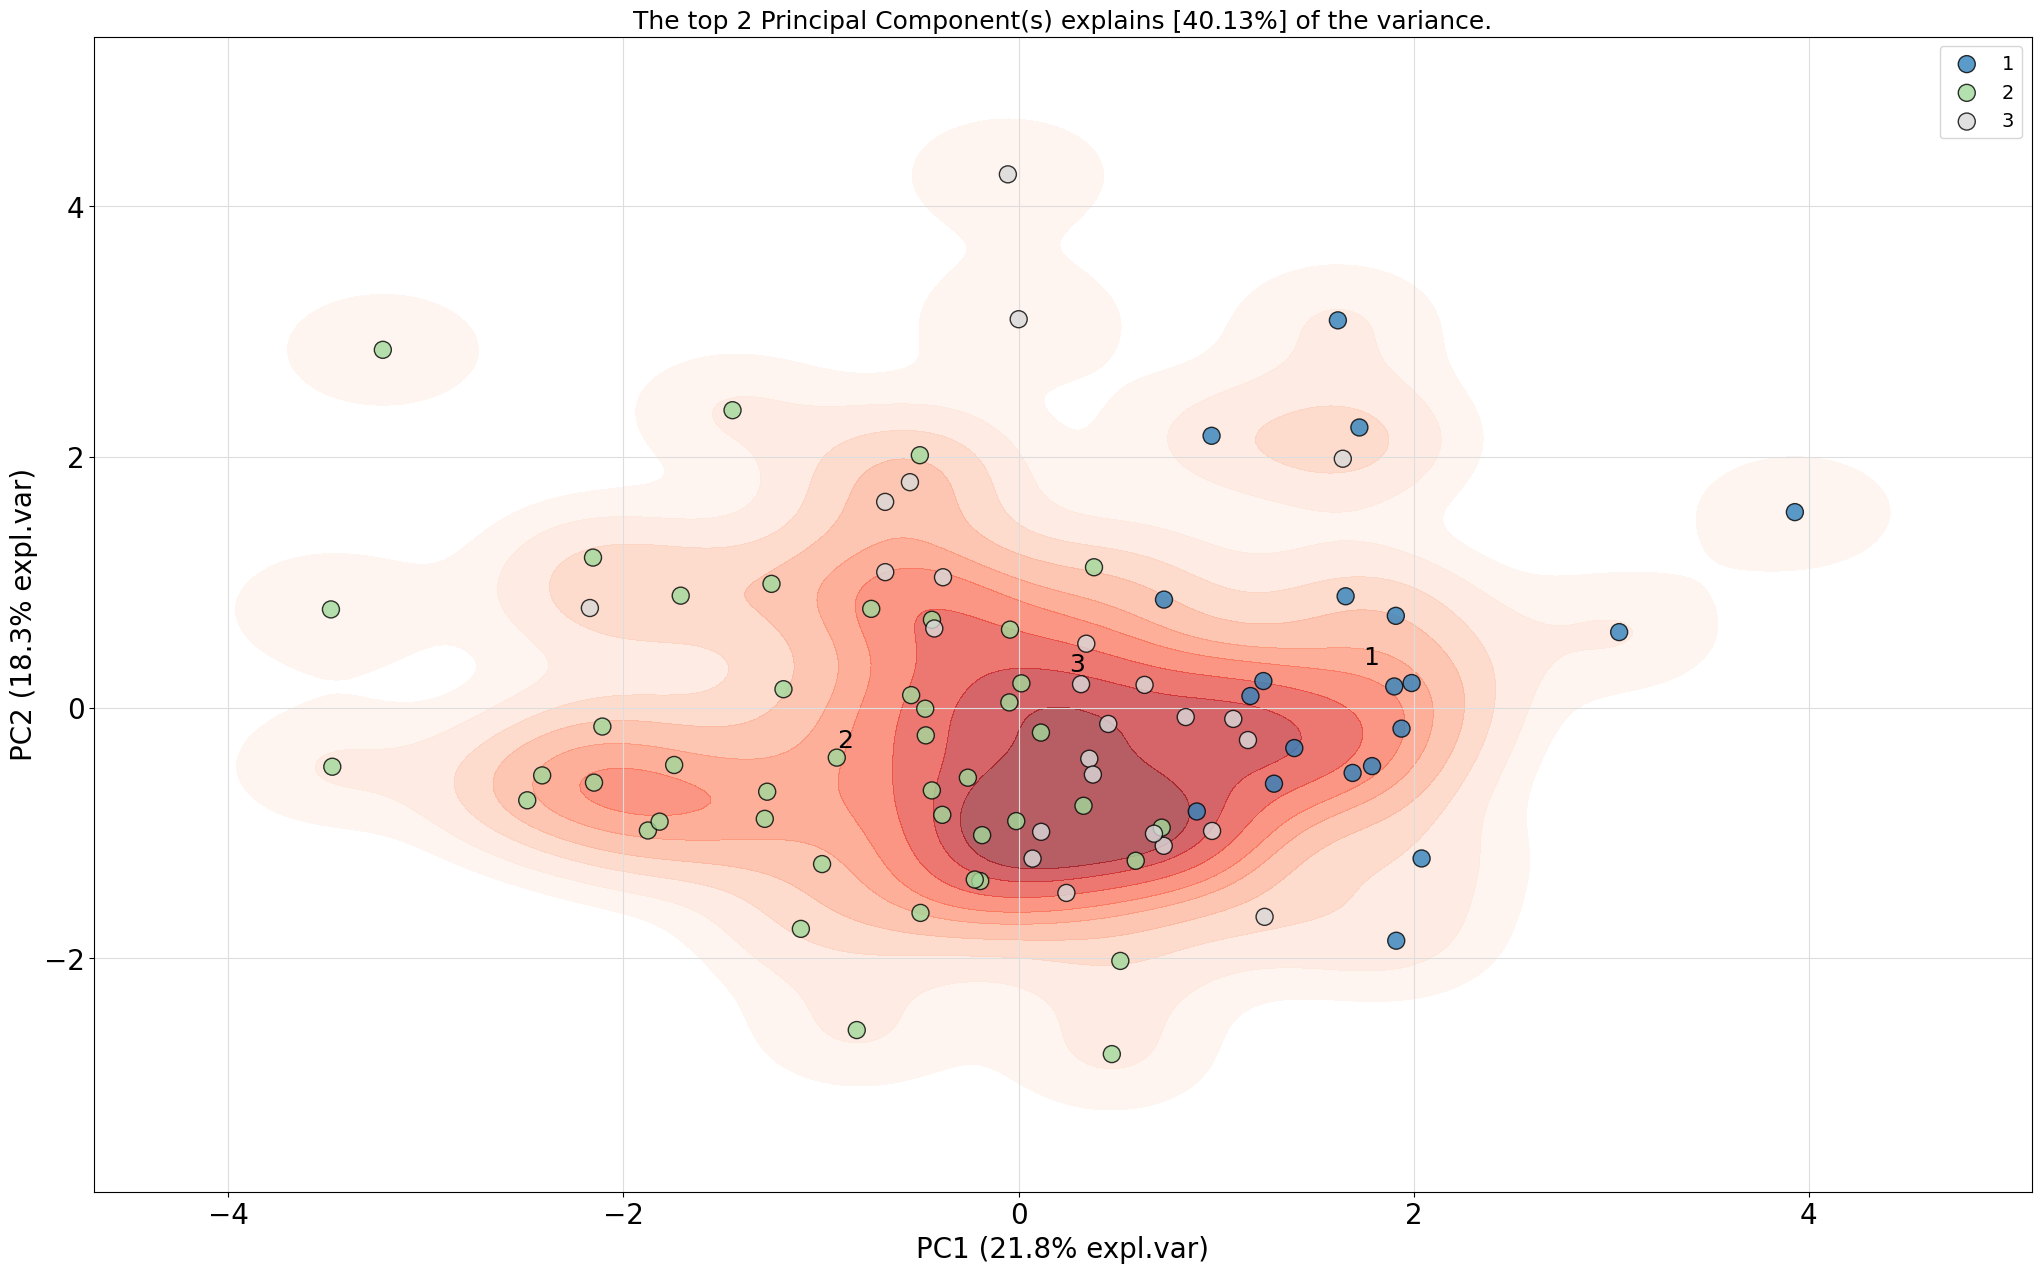

In [13]:
model = pca(n_components=2,normalize=True)
features = akuna_segmentation_data.drop(columns="SegmentKM")
segments = akuna_segmentation_data.SegmentKM

# Fit transform
results = model.fit_transform(features,verbose=False)
# Make biplot with the number of features
# Strenght of the loadings are shown in two colors (red=strong, blue=weak)
fig, ax = model.biplot(labels=segments,verbose=0,density=True);

PCA biplot (PC1 on X, PC2 on Y): the first two PCs explain ~40% of total variance, indicating moderate dimensionality reduction.
* PC1 (left→right) contrasts technical/on-field priorities (durability, softness, lightness, fit, ball control) with aesthetic/brand + easy-wear cues (brand reputation, color options, ease of fit, perceived quality).
* PC2 (bottom→top) captures a secondary “style/brand & convenience” vs “pure performance feel” gradient.

Clusters overlap in the PC1–PC2 plane, consistent with weak separation (low silhouette) and soft preference profiles.

n Segments solution using Hierarchical Clustering

In [14]:
hc = AgglomerativeClustering(n_clusters = 3,linkage="ward")
hc.fit(akuna_segmentation_data)

akuna_segmentation_data["SegmentHC"] = hc.labels_ + 1
akuna_segmentation_data.head(8)

,Boot weight,Softness of material,Foot Fit,Durability,Brand Reputation,Ball control,Ease of fit,Color options,Quality Preference,SegmentKM,SegmentHC
1,2.0,2.0,5.0,4.0,5.0,5.0,5.0,2.0,5.0,1,2
2,3.0,3.0,5.0,5.0,2.0,2.0,2.0,1.0,2.0,2,3
3,2.0,4.0,5.0,5.0,4.0,4.0,2.0,1.0,4.0,2,3
5,2.0,3.0,5.0,4.0,3.0,5.0,1.0,1.0,5.0,2,3
6,3.0,1.0,5.0,5.0,2.0,3.0,5.0,1.0,4.0,3,1
7,4.0,3.0,4.0,4.0,1.0,4.0,1.0,1.0,2.0,2,3
9,4.0,4.0,3.0,5.0,2.0,5.0,2.0,1.0,4.0,2,1
13,4.0,3.0,4.0,5.0,2.0,5.0,3.0,2.0,4.0,3,1


In [15]:
(akuna_segmentation_data.groupby("SegmentKM")["SegmentHC"].nunique()==1).all() and \
(akuna_segmentation_data.groupby("SegmentHC")["SegmentKM"].nunique()==1).all()

np.False_

Segments sizes

In [16]:
akuna_segmentation_data_SizesHC = pd.DataFrame(akuna_segmentation_data.groupby("SegmentHC").size(),columns=["Size"]).T
akuna_segmentation_data_SizesHC.insert(0,"Population",len(akuna_segmentation_data))
akuna_segmentation_data_SizesHC.loc["%"] = akuna_segmentation_data_SizesHC.iloc[0].div(akuna_segmentation_data_SizesHC.iloc[0,0]).mul(100).astype(int)
akuna_segmentation_data_SizesHC

SegmentHC,Population,1,2,3
Size,90,31,19,40
%,100,34,21,44


Dendrogram (Ward method) using scipy package

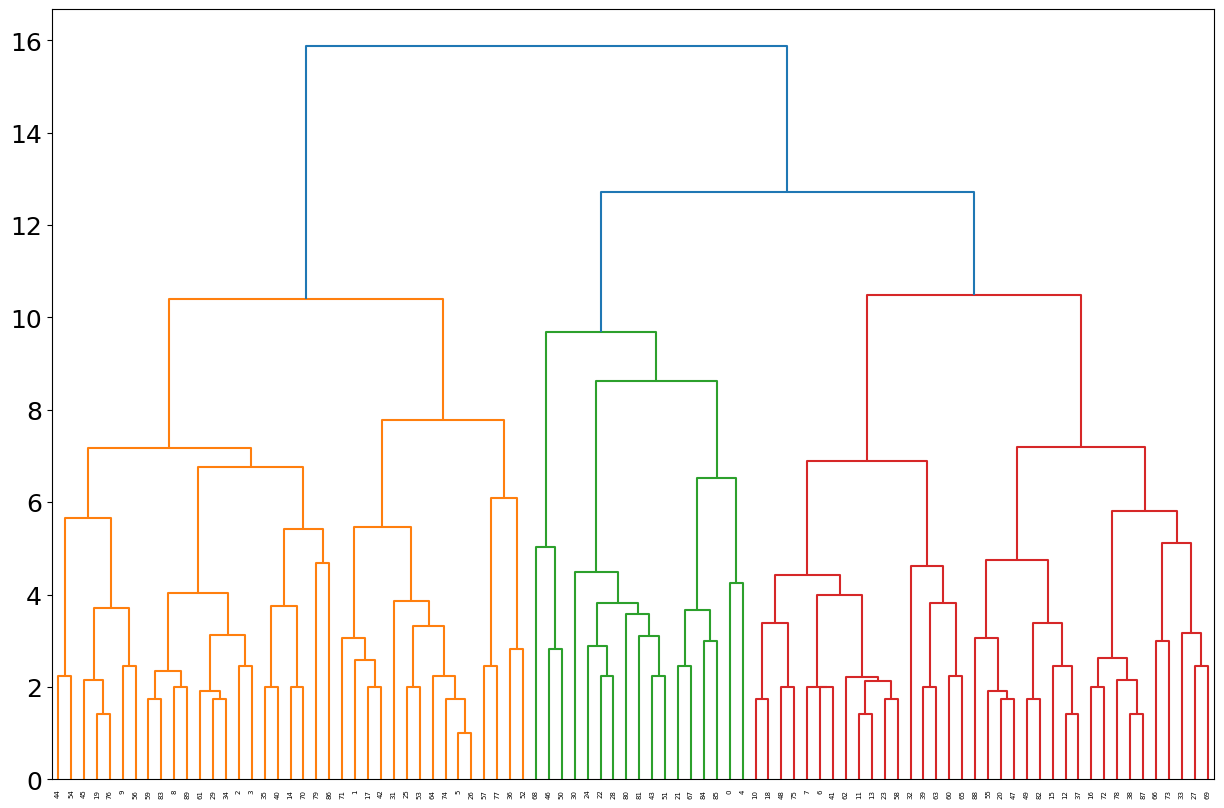

In [17]:
X = akuna_segmentation_data.drop(columns=["SegmentKM","SegmentHC"])

# Plot the hierarchical clustering as a dendrogram.
tree = hierarchy.linkage(X,'ward')
plt.figure(figsize=(15,10))
dn = hierarchy.dendrogram(tree)

Descriptor Analysis
Import Descriptor Data and add segment labels

In [61]:
ita_indices = range(5, 14)
eng_indices = range(58, 67)

clean_names = [
    "Gender", "Occupation", "Region", "Age", 
    "Role", "Frequency", "Ground", "LastPurchase", "ShopPlace"
]
akuna_descriptor_data = pd.DataFrame()

for i in range(len(clean_names)):
    ita_col_name = akuna_data.columns[ita_indices[i]]
    eng_col_name = akuna_data.columns[eng_indices[i]]
    akuna_descriptor_data[clean_names[i]] = akuna_data[eng_col_name].combine_first(akuna_data[ita_col_name])

akuna_descriptor_data.dropna(inplace=True)
print(akuna_descriptor_data.head())

    Gender  Occupation     Region   Age            Role  \
1     Male     Student    Abroad   25.0        Defender   
2  Maschio  Dipendente     Puglia  30.0  Centrocampista   
3     Male     Student    Abroad   29.0      Midfielder   
5  Maschio    Studente     Puglia  24.0       Difensore   
6     Male    Employee  Lombardia  30.0        Defender   

                      Frequency            Ground          LastPurchase  \
1  Between three and ten times   Artificial turf          Less than 80€   
2                   Meno di tre         Sintetico           Meno di 80€   
3        Less than three times   Artificial turf          Less than 80€   
5                   Meno di tre         Sintetico           Meno di 80€   
6        Less than three times   Artificial turf   Between 80€ and 100€   

               ShopPlace  
1  Physical on-site shop  
2     recarti in negozio  
3  Physical on-site shop  
5     recarti in negozio  
6  Physical on-site shop  


In [29]:
unique_per_col = {col: akuna_descriptor_data[col].unique()
                  for col in akuna_descriptor_data.columns}
for col in akuna_descriptor_data.columns:
    print(col, "->", akuna_descriptor_data[col].dropna().unique())

Gender -> <StringArray>
[                       'Male',                     'Maschio',
                     'Femmina',           'Prefer not to say',
 'Preferisco non specificarlo']
Length: 5, dtype: str
Occupation -> <StringArray>
[              'Student',            'Dipendente',              'Studente',
              'Employee', 'Libero professionista',                 'Altro',
                 'Other']
Length: 7, dtype: str
Region -> <StringArray>
[          'Abroad ',            'Puglia',         'Lombardia',
           'Liguria',          'Calabria',             'Lazio',
            'Marche',    'Emilia Romagna',          'Piemonte',
           'Sicilia', 'Fuori dall'Italia',            'Veneto',
            'Molise']
Length: 13, dtype: str
Age -> [25. 30. 29. 24. 23. 21. 18. 67. 20. 28. 22. 27. 32. 26. 31. 15. 17. 14.]
Role -> <StringArray>
[      'Defender', 'Centrocampista',     'Midfielder',      'Difensore',
     'Attaccante',       'Portiere']
Length: 6, dtype: str
Frequenc

In [43]:
for col in akuna_descriptor_data.columns:
    print("\n", col)
    print(akuna_descriptor_data[col].value_counts(dropna=False))


 Gender
Gender
Maschio                        80
Male                            4
Femmina                         4
Prefer not to say               1
Preferisco non specificarlo     1
Name: count, dtype: int64

 Occupation
Occupation
Studente                 45
Dipendente               29
Libero professionista     7
Altro                     4
Student                   2
Employee                  2
Other                     1
Name: count, dtype: int64

 Region
Region
Lombardia            50
Liguria              13
Lazio                 9
Puglia                4
Calabria              3
Abroad                2
Sicilia               2
Fuori dall'Italia     2
Marche                1
Emilia Romagna        1
Piemonte              1
Veneto                1
Molise                1
Name: count, dtype: int64

 Age
Age
23.0    29
24.0    11
28.0     6
20.0     5
27.0     5
26.0     5
25.0     4
30.0     4
21.0     4
22.0     4
18.0     3
32.0     3
29.0     2
67.0     1
31.0     1
15.0     1
17

In [62]:
encoding_maps = {
    'Gender':{
    'Male': 0, 'Maschio': 0,
    'Female': 1, 'Femmina': 1},
    
    'Occupation': {
    'Studente' : 'Student', 'Student' : 'Student',
    'Dipendente' : 'Employee', 'Employee' : 'Employee',
    'Libero professionista' : 'Freelance', 'Freelance' : 'Freelance',
    'Altro' : 'Other', 'Other' : 'Other'},

    'Role': {
    'Difensore' : 'Defender', 'Defender' : 'Defender',
    'Attaccante' : 'Striker', 'Striker' : 'Striker',
    'Portiere' : 'Keeper', 'Keeper' : 'Keeper',
    'Centrocampista' : 'Midfielder', 'Midfielder' : 'Midfielder'},

    'Ground':{
    'Sintetico' : 'Artificial turf ', 'Artificial turf ' : 'Artificial turf ',
    'Naturale' : "Grass", 'Grass' : "Grass",
    'Alterno queste due superfici' : 'Mixed'},

    'ShopPlace':{
    'recarti in negozio':0, 'Physical on-site shop':0,
    'andare online':1},

    'LastPurchase': {
    'Less than 80€': 1, 'Meno di 80€': 1,
    'Between 80€ and 100€': 2, 'Tra gli 80€ e i 100€': 2,
    'Between 100€ and 150€': 3, 'Tra i 100€ e i 150€': 3,
    'More than 150€': 4, 'Più di 150€': 4},

    'Frequency' :{
    'Less than three times ': 1, 'Meno di tre': 1,
    'Between three and ten times ': 2, 'Tra le tre e le dieci': 2, 
    'More than ten times ': 3, 'Più di dieci': 3}
}

# Applicazione delle trasformazioni
for col, mapping in encoding_maps.items():
    if col in akuna_descriptor_data.columns:
        akuna_descriptor_data[col] = akuna_descriptor_data[col].map(mapping)
        
# Verifica i risultati
print(akuna_descriptor_data.head())

   Gender Occupation     Region   Age        Role  Frequency  \
1     0.0    Student    Abroad   25.0    Defender          2   
2     0.0   Employee     Puglia  30.0  Midfielder          1   
3     0.0    Student    Abroad   29.0  Midfielder          1   
5     0.0    Student     Puglia  24.0    Defender          1   
6     0.0   Employee  Lombardia  30.0    Defender          1   

             Ground  LastPurchase  ShopPlace  
1  Artificial turf              1          0  
2  Artificial turf              1          0  
3  Artificial turf              1          0  
5  Artificial turf              1          0  
6  Artificial turf              2          0  


In [73]:
df_con_nan = akuna_descriptor_data[akuna_descriptor_data.isnull().any(axis=1)]
print(df_con_nan)
akuna_descriptor_data.dropna(inplace=True)

    Gender Occupation     Region   Age      Role  Frequency            Ground  \
17     0.0   Employee    Liguria  23.0  Defender          1               NaN   
66     NaN      Other  Lombardia  27.0  Defender          2  Artificial turf    
94     NaN   Employee  Lombardia  31.0    Keeper          1  Artificial turf    

    LastPurchase  ShopPlace  SegmentKM  
17             2          0          3  
66             1          0          2  
94             1          0          3  


In [74]:
akuna_descriptor_data["SegmentKM"] = akuna_segmentation_data["SegmentKM"]
print("DataFrame: akuna_descriptor_data (with 'SegmentKM' column added)")
akuna_descriptor_data.head(8)

DataFrame: akuna_descriptor_data (with 'SegmentKM' column added)


,Gender,Occupation,Region,Age,Role,Frequency,Ground,LastPurchase,ShopPlace,SegmentKM
1,0.0,Student,Abroad,25.0,Defender,2,Artificial turf,1,0,1
2,0.0,Employee,Puglia,30.0,Midfielder,1,Artificial turf,1,0,2
3,0.0,Student,Abroad,29.0,Midfielder,1,Artificial turf,1,0,2
5,0.0,Student,Puglia,24.0,Defender,1,Artificial turf,1,0,2
6,0.0,Employee,Lombardia,30.0,Defender,1,Artificial turf,2,0,3
7,0.0,Student,Lombardia,24.0,Striker,3,Artificial turf,1,0,2
9,0.0,Student,Liguria,24.0,Defender,1,Artificial turf,2,0,2
13,0.0,Student,Liguria,23.0,Midfielder,1,Artificial turf,2,0,3



Segment description

In [75]:
cols_mean = ['Gender', 'Age', 'LastPurchase', 'ShopPlace']
agg_dict = {col: 'mean' for col in cols_mean}

segments_summary = akuna_descriptor_data.groupby("SegmentKM").agg(agg_dict).T
pop_mean = akuna_descriptor_data[cols_mean].mean()

akuna_descriptor_data_Summary = segments_summary.copy()
akuna_descriptor_data_Summary.insert(0, "Population", pop_mean)
def style_cols(col):
    if col.name == "Population": 
        return ["background-color: white"] * len(col)
    
    segment_data = akuna_descriptor_data[akuna_descriptor_data["SegmentKM"] == col.name]
    rest_pop_data = akuna_descriptor_data[akuna_descriptor_data["SegmentKM"] != col.name]
    
    colors = []
    for var, var_segment_mean in col.items():
        _, p_value = stats.ttest_ind(segment_data[var], rest_pop_data[var], nan_policy='omit', equal_var=False)
        
        if p_value < 0.05:
            color = "background-color: #2ecc71; color: white" if var_segment_mean > rest_pop_data[var].mean() else "background-color: #e74c3c; color: white"
        elif p_value < 0.1:
            color = "background-color: #90ee90" if var_segment_mean > rest_pop_data[var].mean() else "background-color: #f1807e"
        else: 
            color = "background-color: white"
        colors.append(color)
    return colors

styled_table = akuna_descriptor_data_Summary.style.apply(style_cols).format("{:.1f}")

styled_table

SegmentKM,Population,1,2,3
Gender,0.0,0.1,0.0,0.0
Age,24.4,23.2,25.2,24.0
LastPurchase,1.8,2.1,1.5,1.9
ShopPlace,0.0,0.1,0.0,0.0


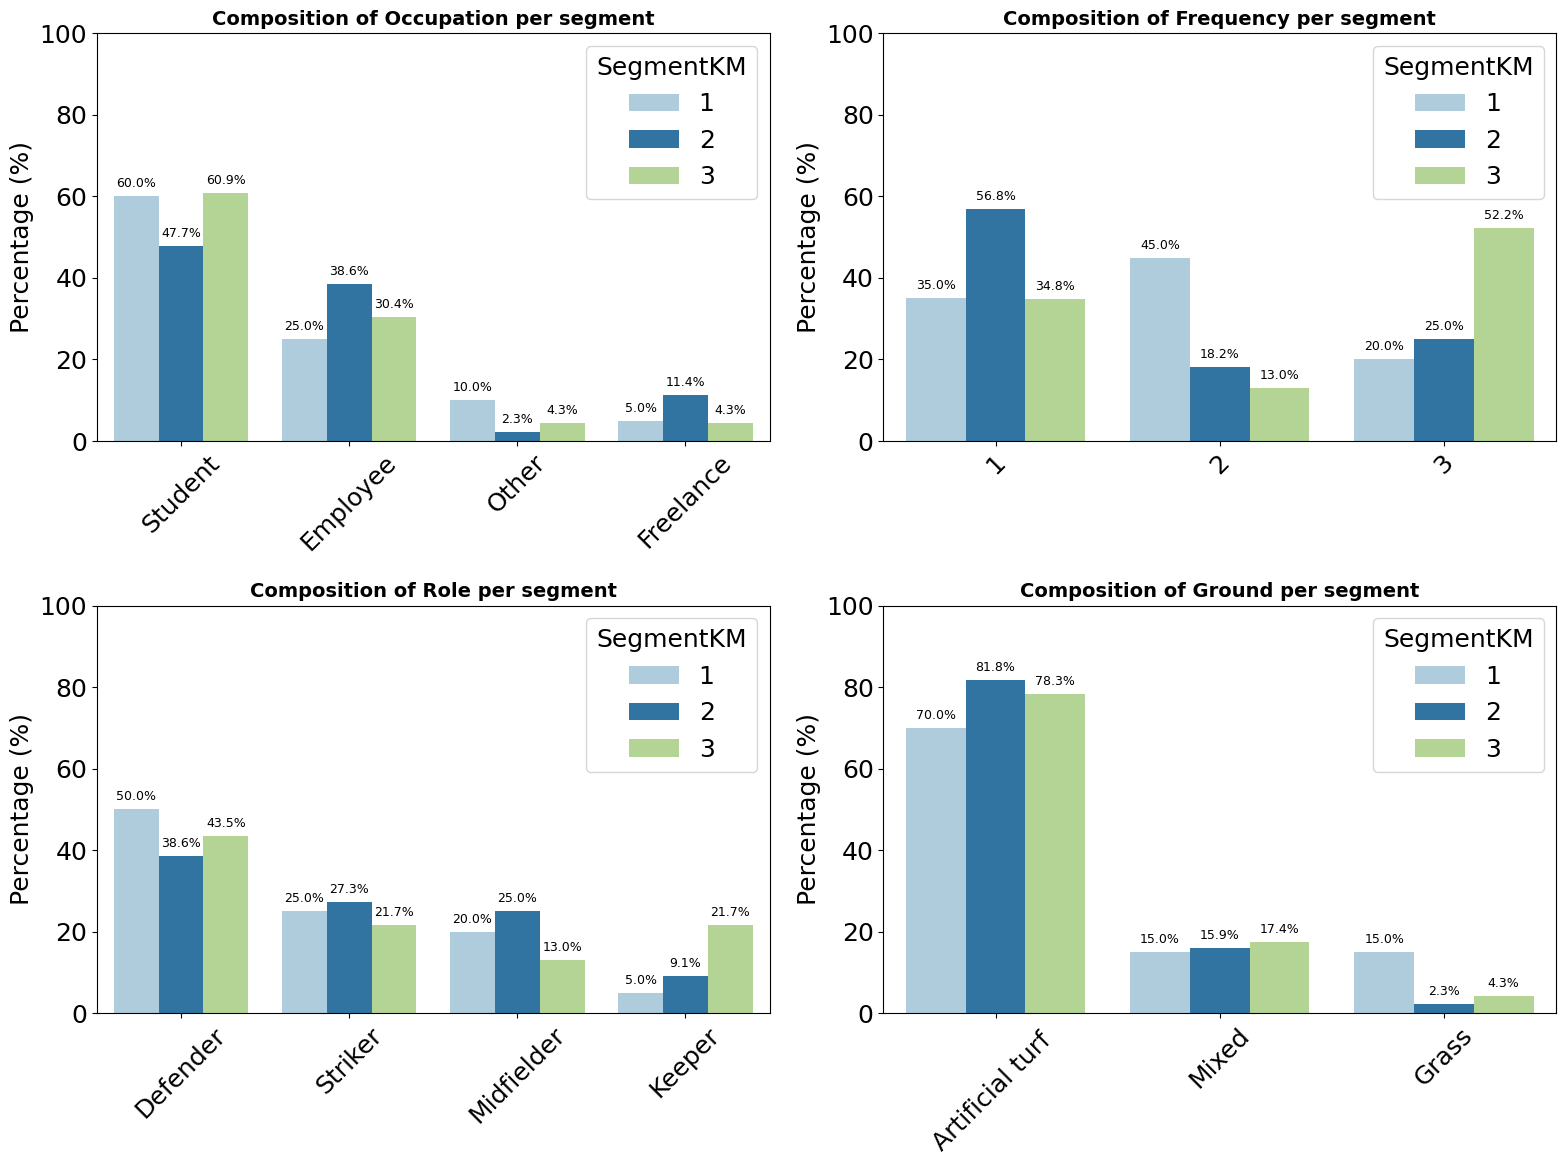

In [76]:
vars_to_plot = ['Occupation', 'Frequency', 'Role', 'Ground']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten()

for i, var in enumerate(vars_to_plot):
    prop_df = (akuna_descriptor_data.groupby('SegmentKM')[var]
               .value_counts(normalize=True)
               .rename('percentage')
               .reset_index())
    
    prop_df['percentage'] *= 100

    sns.barplot(
        data=prop_df, 
        x=var, 
        y='percentage', 
        hue='SegmentKM', 
        ax=axes[i],
        palette='Paired'
    )
    
    axes[i].set_title(f'Composition of {var} per segment', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Percentage (%)')
    axes[i].set_ylim(0, 100) 
    axes[i].tick_params(axis='x', rotation=45)
    
    # Aggiunta etichette percentuali sopra le barre (opzionale)
    for p in axes[i].patches:
        if p.get_height() > 0:
            axes[i].annotate(f'{p.get_height():.1f}%', 
                             (p.get_x() + p.get_width() / 2., p.get_height()), 
                             ha = 'center', va = 'center', 
                             xytext = (0, 9), 
                             textcoords = 'offset points',
                             fontsize=9)

plt.tight_layout()
plt.show()

Descriptor Space using PCA (with pca package)

In [66]:
# Produce a PCA Biplot (i.e. PCA plot + Loadings plot) also featuring kernel densities using the pca package (documentation available at https://erdogant.github.io/pca)

cols_for_pca = ['Gender', 'Age', 'LastPurchase', 'Frequency', 'ShopPlace']

features_pca = akuna_descriptor_data[cols_for_pca]

model = pca(n_components=2, normalize=True)
results = model.fit_transform(features_pca, verbose=False)

fig, ax = model.biplot(
    labels=akuna_descriptor_data.SegmentKM, 
    verbose=0, 
    density=True,
    arrowdict={'color': 'red', 'linewidth': 1.5}  )           

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Classification model

Nei prossimi risultati il modello tiene il segmento 1 come baseline

In [79]:
formula = "SegmentKM ~ C(Occupation) + C(Role) + C(Ground) + Age + LastPurchase + Frequency"
model_logit = smf.mnlogit(formula=formula, data=akuna_descriptor_data).fit()
print(model_logit.summary())

Optimization terminated successfully.
         Current function value: 0.874406
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:              SegmentKM   No. Observations:                   87
Model:                        MNLogit   Df Residuals:                       63
Method:                           MLE   Df Model:                           22
Date:                Thu, 12 Feb 2026   Pseudo R-squ.:                  0.1547
Time:                        13:49:04   Log-Likelihood:                -76.073
converged:                       True   LL-Null:                       -89.999
Covariance Type:            nonrobust   LLR p-value:                    0.1807
               SegmentKM=2       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.0898      3.181      0.028      0.977      

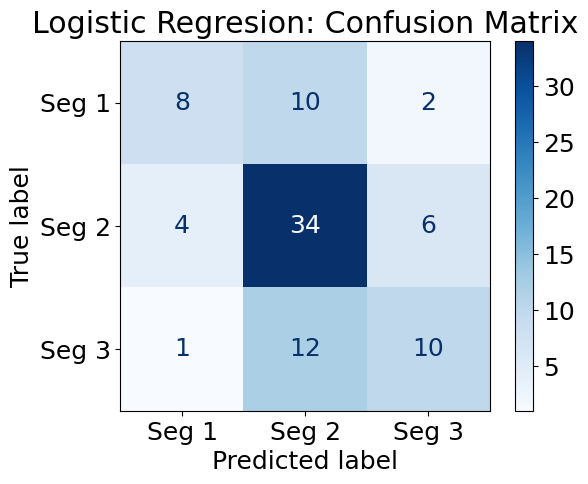

In [80]:
pred_table = model_logit.pred_table()
disp = ConfusionMatrixDisplay(confusion_matrix=pred_table, 
                              display_labels=['Seg 1', 'Seg 2', 'Seg 3'])
disp.plot(cmap='Blues', values_format='.0f')
ax.grid(False)
plt.title("Logistic Regresion: Confusion Matrix")
plt.show()

In [81]:
akuna_descriptor_data["SegmentKM"] = akuna_descriptor_data["SegmentKM"].astype(int)
model_ols = smf.ols(
    "SegmentKM ~ C(Occupation) + C(Role) + C(Ground) + Age + LastPurchase + Frequency",
    data=akuna_descriptor_data
).fit()

print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:              SegmentKM   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.8873
Date:                Thu, 12 Feb 2026   Prob (F-statistic):              0.556
Time:                        13:49:13   Log-Likelihood:                -87.366
No. Observations:                  87   AIC:                             198.7
Df Residuals:                      75   BIC:                             228.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

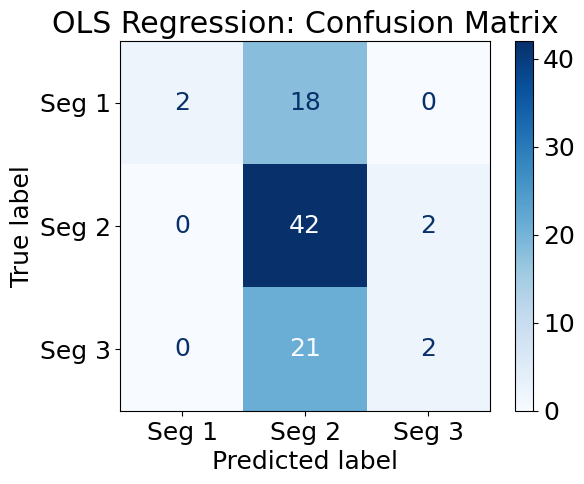

In [82]:

# True labels
y_true = akuna_descriptor_data["SegmentKM"].astype(int)

# Predizioni continue -> classi (1-3)
y_pred_cont = model_ols.predict(akuna_descriptor_data)
y_pred = np.rint(y_pred_cont).astype(int)   # round
y_pred = np.clip(y_pred, 1, 3)              # forza nel range [1,3]

# Confusion matrix
pred_table = confusion_matrix(y_true, y_pred, labels=[1, 2, 3])

disp = ConfusionMatrixDisplay(confusion_matrix=pred_table,
                              display_labels=['Seg 1', 'Seg 2', 'Seg 3'])
disp.plot(cmap='Blues', values_format='.0f')
plt.grid(False)
plt.title("OLS Regression: Confusion Matrix")
plt.show()

Classification using Random Forest Classifier (from sklearn package)

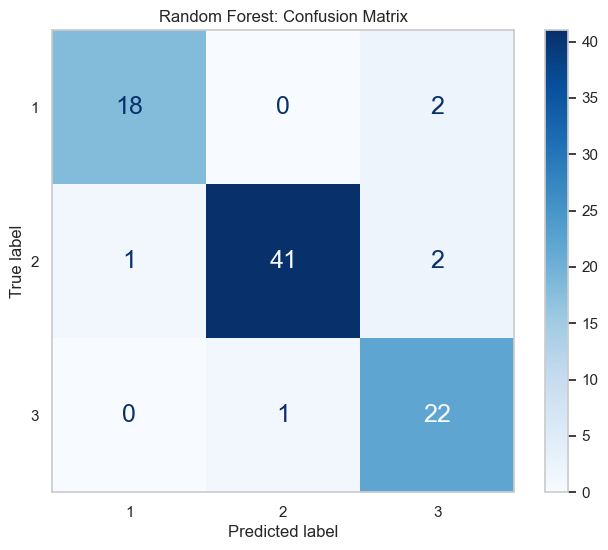

In [82]:
cols_numeric = ['Gender', 'Age', 'LastPurchase', 'Frequency', 'ShopPlace']
cols_nominal = ['Occupation', 'Role', 'Ground']

X = pd.concat([
    akuna_descriptor_data[cols_numeric], 
    pd.get_dummies(akuna_descriptor_data[cols_nominal])
], axis=1)

y = akuna_descriptor_data.SegmentKM

rf = RandomForestClassifier(n_estimators=30, random_state=42)
rf.fit(X, y)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay.from_estimator(rf, X, y, cmap='Blues', ax=ax)
ax.grid(False) 
plt.title("Random Forest: Confusion Matrix")
plt.show()


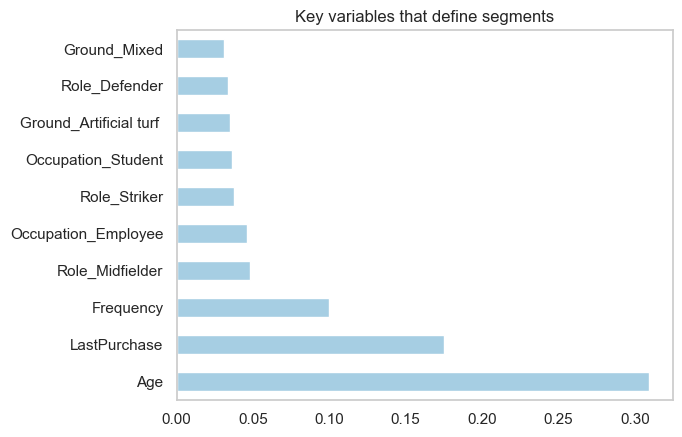

In [86]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

importances.head(10).plot(kind='barh', cmap='Paired')
plt.title("Key variables that define segments")
plt.gca().grid(False) 
plt.show()

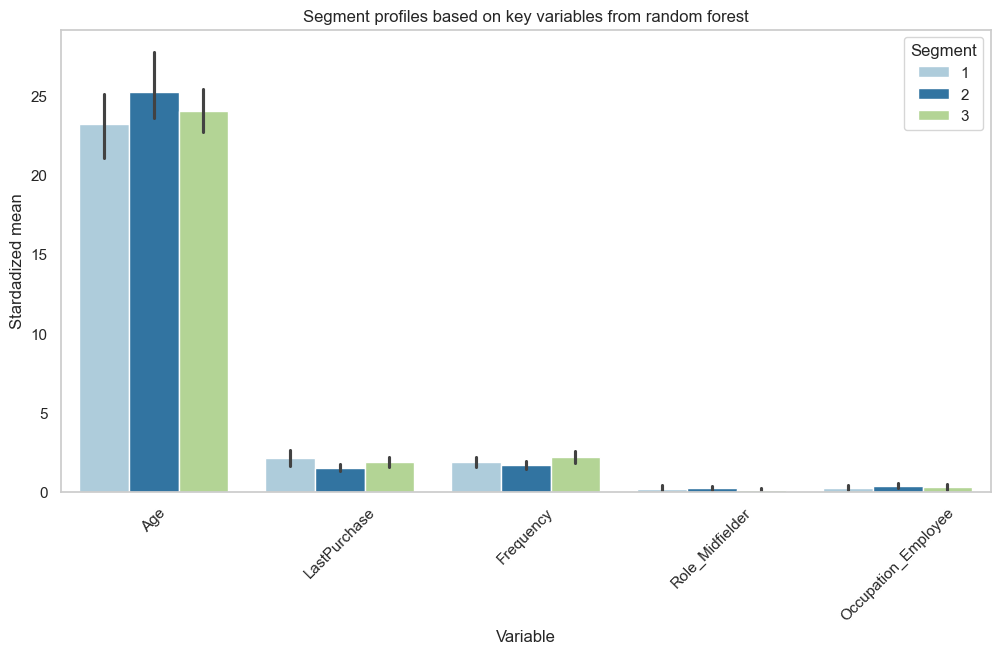

In [87]:
top_features = importances.head(5).index.tolist()

df_plot = X[top_features].copy()
df_plot['Segment'] = y

df_melted = df_plot.melt(id_vars='Segment', var_name='Variable', value_name='Value')

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x='Variable', y='Value', hue='Segment', palette='Paired')

plt.title("Segment profiles based on key variables from random forest")
plt.ylabel("Stardadized mean")
plt.xticks(rotation=45)
plt.grid(False) 
plt.show()